# Maize Leaf Disease Classification using Vision Transformer (ViT)


<img src='https://imgs.search.brave.com/06oyAqYkjcVznl17oNdPhEMbiFV4DcV1YGrqbb52NGw/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9sZWFy/bm9wZW5jdi5jb20v/d3AtY29udGVudC91/cGxvYWRzLzIwMjMv/MDIvaW1hZ2UtOS0x/MDI0eDUzOC5wbmc'>

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import os
from glob import glob
from tqdm import tqdm
import argparse
import random

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
from torchinfo import summary
from going_modular.going_modular import engine
from going_modular.going_modular.predictions import pred_and_plot_image

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, torch.__version__)

# Define the data directory
data_dir = 'data'
out_model_dir = 'models'

cuda 2.6.0+cu124


## Define the Configurations

In [2]:
IMG_SIZE = 256
NUM_CHANNELS = 3
BATCH_SIZE = 32
RANDOM_SEED = 42

# Set the seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

## Dataset and DataLoader

In [3]:
# Custom image dataset class
class ImageDataset(Dataset):
    """
    Class for loading simple text-based images into PyTorch datasets.

    A text-based dataset where each image is associated with a label from a given
    list of labels.

    Args:
        data_dir: Path to directory containing 'images' folder.
        transform: Optional transformation function or list. Applied on each input
        example (image) before being fed into the model.

    Attributes:
    - `len`: Number of images in dataset.
    - `image_paths`: List of file paths for all images in the dataset.
    - `labels`: List of corresponding labels for the images.
    - `class_to_idx`: Dictionary mapping class labels to their respective indices.

    To use this dataset, you would create an instance via:
    ```python
    dataset = ImageDataset("path/to/data")
    ```

    The `transform` parameter is optional and can be used to process each input example before feeding it into a
    model. The returned examples are a tuple containing the transformed image and its corresponding label.
    """

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.image_paths = glob(os.path.join(data_dir, 'images', '*', '*.jpg'))
        self.labels = []
        self.class_to_idx = {}

        for path in self.image_paths:
            label = path.split('\\')[-2]
            self.labels.append(label)

        for i, c in enumerate(set(self.labels)):
            self.class_to_idx[c] = i

        self.labels = [self.class_to_idx[l] for l in self.labels]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Define the transforms
manual_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
# Create an image dataset object
dataset = ImageDataset(os.path.join(data_dir), transform=manual_transforms)

# Split the data into training and testing
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print('Number of training images:', len(train_dataset))
print('Number of testing images:', len(test_dataset))

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print(f'{len(train_dataset)//BATCH_SIZE} batches of {BATCH_SIZE} images in the training data.')
print(f'{len(test_dataset)//BATCH_SIZE} batches of {BATCH_SIZE} images in the testing data.')

Number of training images: 3349
Number of testing images: 838
104 batches of 32 images in the training data.
26 batches of 32 images in the testing data.


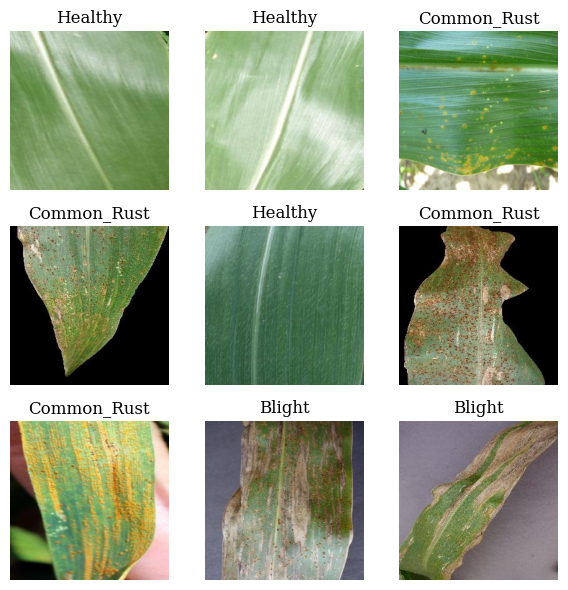

In [6]:
# Plot sample image
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
axes = axes.flatten()

for ax in axes:
    random_id = random.randint(0, len(train_dataset))
    img, label = train_dataset.__getitem__(random_id)
    img = img.permute(1, 2, 0).numpy()
    label_name = [k for k, v in dataset.class_to_idx.items() if label == v][0]
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Model Building

### `PatchEmbedding` class

**Patch embedding** transforms an input image into a sequence of patch vectors, enabling the use of transformers for vision tasks.

- The image is split into non-overlapping patches (e.g., 16×16).
- Each patch is flattened and projected into a vector of fixed dimension using a `Conv2d` layer with `kernel_size = stride = patch_size`.
- The output is a sequence of patch embeddings with shape `(batch_size, num_patches, embedding_dim)`.

This allows transformers to process images similarly to how they handle word tokens in NLP.

In [7]:
class PatchEmbedding(nn.Module):
    """
    Converts an input image into a sequence of patch embeddings for Vision Transformers.

    Args:
        in_channels (int): Number of input image channels. Default is 3 (RGB).
        patch_size (int): Size of each square patch (e.g., 16 for 16x16 patches).
        embedding_dim (int): Dimension of the linear patch embedding.
        image_size (int): Height/Width of the input image (assumes square input).
        dropout (float): Dropout probability after embedding.
    """
    def __init__(self, 
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768,
                 image_size: int = 256,
                 dropout: float = 0.0):
        super().__init__()
        
        assert image_size % patch_size == 0, \
            f"Image size ({image_size}) must be divisible by patch size ({patch_size})"

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = (image_size // patch_size) ** 2

        # Conv2d turns image into patch embeddings
        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Learnable class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Learnable positional embeddings (1 for [CLS] + num_patches)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            Tensor: Patch + class token embeddings of shape (B, N+1, D)
        """
        B = x.shape[0]

        # Project patches
        x = self.projection(x)                # (B, D, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)      # (B, N, D), where N = num_patches

        # Add class token
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_token, x), dim=1)          # (B, N+1, D)

        # Add positional encoding and apply dropout
        x = x + self.position_embedding               # (B, N+1, D)
        return self.dropout(x)

In [8]:
# Let's test it on a single image
# Create an object of the PatchEmbedding class 
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768,
    image_size=256,
    dropout=0.3
)

# Pass a single image through
image, label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Input image shape:', image.shape)

patch_embedded_image = patchify(image.unsqueeze(0))
print('Output patch embedding shape:', patch_embedded_image.shape)

Input image shape: torch.Size([3, 256, 256])
Output patch embedding shape: torch.Size([1, 257, 768])


In [9]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f'Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimensions]')

tensor([[[ 4.8488,  0.3113, -0.0000,  ..., -2.7804, -1.5810,  1.3166],
         [ 0.4118,  0.0893, -0.0123,  ...,  0.0000, -1.0052,  0.0990],
         [-0.0000,  0.0000, -1.1365,  ..., -0.0000, -0.0000, -0.2182],
         ...,
         [ 0.4836, -0.1265, -0.0000,  ..., -0.2648,  0.0000, -1.6243],
         [ 0.1366,  0.8810,  0.9330,  ..., -1.2958, -0.6096,  1.2434],
         [ 1.8575,  0.0000, -0.3810,  ..., -0.4288,  1.1905,  0.0000]]],
       grad_fn=<MulBackward0>)
Patch embedding shape: torch.Size([1, 257, 768]) -> [batch_size, number_of_patches, embedding_dimensions]


### `Multi-Head Attention` (MHA) Block
Multi-Head Attention is a key component of transformer models that allows the network to attend to different parts of a sequence simultaneously from multiple representation subspaces.

- **Multiple heads** learn different types of relationships in parallel.
- Each head performs scaled dot-product attention independently.
- The results from all heads are concatenated and linearly transformed.

In Vision Transformers (ViT), MHA enables the model to learn relationships between image patches, allowing for global context understanding.

In [10]:
class MultiHeadAttentionBlock(nn.Module):
    """
    A single Multi-Head Self-Attention block with pre-layer normalization 
    and residual connection, as used in Transformer encoders.

    Args:
        embedding_dim (int): Dimensionality of input embeddings.
        num_heads (int): Number of attention heads.
        attn_dropout (float): Dropout rate applied within attention mechanism.
    """
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attn_dropout: float = 0.0):
        super().__init__()

        # Layer normalization before attention (Pre-Norm)
        self.norm = nn.LayerNorm(embedding_dim)

        # Multi-head self-attention layer
        self.attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True  # Output shape: (B, N, D)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input tensor of shape (B, N, D)

        Returns:
            Tensor: Output tensor of shape (B, N, D)
        """
        x_norm = self.norm(x)
        attn_output, _ = self.attn(
            query=x_norm,
            key=x_norm,
            value=x_norm
        )
        
        return x + attn_output  # Residual connection

### `MLP` Block

The **MLP Block** in Vision Transformers follows each attention layer and helps the model learn complex transformations.

- Consists of two linear layers with a non-linear activation (typically **GELU**).
- Applies **Layer Normalization** before the MLP (Pre-Norm).
- Uses **Dropout** for regularization.
- Includes a **residual connection**: output = input + MLP(normalized input)


In [11]:
class MLPBlock(nn.Module):
    """
    Feed-forward block used in Vision Transformers.
    Applies LayerNorm, two linear layers with GELU activation, and dropout.
    
    Args:
        embedding_dim (int): Input and output embedding dimension.
        mlp_size (int): Hidden layer size in the MLP (usually 4x embedding_dim).
        dropout (float): Dropout rate after each linear layer.
    """
    def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, dropout: float = 0.1):
        super().__init__()

        self.norm = nn.LayerNorm(embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_size, embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input tensor of shape (B, N, D)

        Returns:
            Tensor: Output tensor of same shape (B, N, D) after residual connection.
        """
        x_norm = self.norm(x)
        return x + self.mlp(x_norm)  # Residual connection

### `TransformerEncoder` Block

In [12]:
class TransformerEncoderBlock(nn.Module):
    """
    A single Transformer encoder block composed of:
    - Multi-head self-attention with residual connection
    - MLP block with residual connection

    Args:
        embedding_dim (int): Dimensionality of input embeddings.
        num_heads (int): Number of attention heads.
        mlp_size (int): Hidden layer size in the MLP.
        mlp_dropout (float): Dropout rate in the MLP.
        attn_dropout (float): Dropout rate in the attention layer.
    """
    def __init__(
        self,
        embedding_dim: int = 768,
        num_heads: int = 12,
        mlp_size: int = 3072,
        mlp_dropout: float = 0.1,
        attn_dropout: float = 0.0
    ):
        super().__init__()
        self.attention = MultiHeadAttentionBlock(embedding_dim, num_heads, attn_dropout)
        self.mlp = MLPBlock(embedding_dim, mlp_size, mlp_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input of shape (B, N, D)

        Returns:
            Tensor: Output of shape (B, N, D)
        """
        x = self.attention(x)
        x = self.mlp(x)
        return x
    

In [13]:
# Plot the summary of the transformer encoder
transformer_encoder_block = TransformerEncoderBlock()

summary(
    model=transformer_encoder_block,
    input_size=(1, 257, 768), # (batch_size, num_patches + 1, embedding dimension),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 257, 768]        [1, 257, 768]        --                   True
├─MultiHeadAttentionBlock (attention)              [1, 257, 768]        [1, 257, 768]        --                   True
│    └─LayerNorm (norm)                            [1, 257, 768]        [1, 257, 768]        1,536                True
│    └─MultiheadAttention (attn)                   --                   [1, 257, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 257, 768]        [1, 257, 768]        --                   True
│    └─LayerNorm (norm)                            [1, 257, 768]        [1, 257, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 257, 768]        [1, 257, 768]        --                   True
│    │    └─Linear (0)                     

### `VisionTransformer`
The Vision Transformer (ViT) model applies transformer architecture to image classification tasks. Instead of using convolutions, the image is divided into non-overlapping patches, each treated as a token, which is then processed by transformer layers.

**Key Components:**
1. **Patch Embedding**: The image is split into fixed-size patches, and each patch is embedded into a vector using a linear projection.
2. **Transformer Encoder**: A series of transformer encoder blocks processes the embedded patches. These blocks consist of multi-head self-attention and MLP blocks, both with residual connections.
3. **Classification Head**: The output of the class token (added at the beginning of the sequence) is passed through a linear layer to predict the class label.

**Output**: Class logits for classification.

ViT offers a powerful alternative to convolutional neural networks (CNNs) by leveraging self-attention to learn global relationships between image patches.


In [14]:
class ViT(nn.Module):
    """
        Vision Transformer (ViT) model for image classification.
        The model uses Transformer encoder layers with patch-based image embeddings.

        Args:
            img_size (int): Image size (height and width). Should be divisible by patch_size.
            in_channels (int): Number of input channels in the image (default: 3 for RGB).
            patch_size (int): Size of each patch (e.g., 16 for 16x16 patches).
            embedding_dim (int): Embedding dimension for patch embeddings and transformer layers.
            embedding_dropout (float): Dropout rate applied to patch embeddings.
            num_transformer_layers (int): Number of transformer encoder layers.
            num_heads (int): Number of attention heads in multi-head attention.
            attn_dropout (float): Dropout rate applied in multi-head attention.
            mlp_size (int): Hidden size of MLP layers in transformer blocks.
            mlp_dropout (float): Dropout rate applied in the MLP layers.
            num_classes (int): Number of output classes for classification.
        """
    
    def __init__(self,
                 img_size: int = 256,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768,
                 embedding_dropout: float = 0.1,
                 num_transformer_layers: int = 12,
                 num_heads: int = 12,
                 attn_dropout: float = 0.0,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 num_classes: int = 4):
        super().__init__()

        # Assert image size is divisible by patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size. Got image size: {img_size}, patch size: {patch_size}"

        # Dropout layer for embeddings
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)  # Ensure p is a float value (probability)

        # Patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim,
            image_size=img_size,
            dropout=embedding_dropout  # Make sure this is passed as a float, not a layer object
        )

        # Transformer encoder layers
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout,
                attn_dropout=attn_dropout) for _ in range(num_transformer_layers)]
        )

        # Classifier head: Final Linear Layer for Classification
        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Vision Transformer.

        Args:
            x (Tensor): Input tensor of shape (B, C, H, W), where B is batch size, 
                        C is number of channels, and H, W are image height and width.

        Returns:
            Tensor: Predicted class logits of shape (B, num_classes)
        """
        # Apply patch embedding to the input
        x = self.patch_embedding(x)

        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)

        # Use the output from the class token for classification (the first token in the sequence)
        return self.classifier(x[:, 0])  # The class token is the first token (index 0)

## Training

In [15]:
# Get pretrained weights for ViT-Base
pretrained_vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
pretrained_state_dict = pretrained_vit.state_dict()

# Create ViT model instance
vit = ViT(num_classes=len(dataset.class_to_idx)).to(device)

# Build a new state dict by remapping keys
remapped_state_dict = {}
for new_key, old_key in zip(vit.state_dict().keys(), pretrained_state_dict.keys()):
    if pretrained_state_dict[old_key].shape == vit.state_dict()[new_key].shape:
        remapped_state_dict[new_key] = pretrained_state_dict[old_key]
            
    else:
        print(f"Skipping {old_key} → {new_key} due to shape mismatch: "
              f"{pretrained_state_dict[old_key].shape} vs {vit.state_dict()[new_key].shape}")

# Load the model weights
vit.load_state_dict(remapped_state_dict, strict=False)

# Print the summary of the model
summary(
    model=vit,
    input_size=(BATCH_SIZE, NUM_CHANNELS, IMG_SIZE, IMG_SIZE), # (batch_size, num of channels, height, width),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Skipping conv_proj.weight → patch_embedding.position_embedding due to shape mismatch: torch.Size([768, 3, 16, 16]) vs torch.Size([1, 257, 768])
Skipping conv_proj.bias → patch_embedding.projection.weight due to shape mismatch: torch.Size([768]) vs torch.Size([768, 3, 16, 16])
Skipping encoder.pos_embedding → patch_embedding.projection.bias due to shape mismatch: torch.Size([1, 197, 768]) vs torch.Size([768])
Skipping heads.head.weight → classifier.1.weight due to shape mismatch: torch.Size([1000, 768]) vs torch.Size([4, 768])
Skipping heads.head.bias → classifier.1.bias due to shape mismatch: torch.Size([1000]) vs torch.Size([4])


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 256, 256]    [32, 4]              --                   True
├─PatchEmbedding (patch_embedding)                      [32, 3, 256, 256]    [32, 257, 768]       198,144              True
│    └─Conv2d (projection)                              [32, 3, 256, 256]    [32, 768, 16, 16]    590,592              True
│    └─Dropout (dropout)                                [32, 257, 768]       [32, 257, 768]       --                   --
├─Sequential (transformer_encoder)                      [32, 257, 768]       [32, 257, 768]       --                   True
│    └─TransformerEncoderBlock (0)                      [32, 257, 768]       [32, 257, 768]       --                   True
│    │    └─MultiHeadAttentionBlock (attention)         [32, 257, 768]       [32, 257, 768]       2,363,904            True
│    

In [ ]:
# Setup optimizer with a better learning rate
optimizer = torch.optim.AdamW(params=vit.parameters(),
                              lr=3e-4,  # more stable
                              betas=(0.9, 0.999),
                              weight_decay=0.3)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

In [ ]:
# Save the model
# torch.save(vit.state_dict(), os.path.join(out_model_dir, 'maize_leaf_disease_vit_model_weights.pth'))

## Make Predictions

Random Image Path: data\images\Blight\Corn_Blight (742).JPG


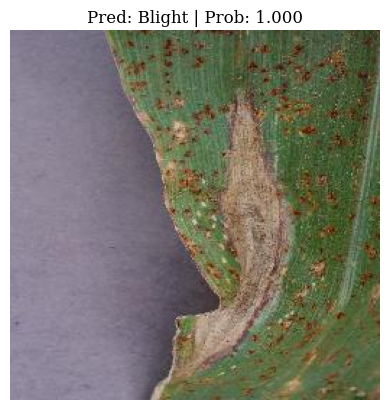

In [18]:
random_image_id = np.random.randint(0, len(dataset))
random_image_path = dataset.image_paths[random_image_id]
print('Random Image Path:', random_image_path)

pred_and_plot_image(
    model=vit,
    class_names=list(dataset.class_to_idx.keys()),
    image_path=random_image_path,
    transform=manual_transforms
)

Random Image Path: data\images\Gray_Leaf_Spot\Corn_Gray_Spot (520).JPG


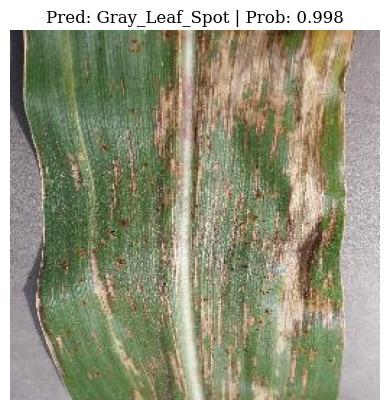

In [24]:
random_image_id = np.random.randint(0, len(dataset))
random_image_path = dataset.image_paths[random_image_id]
print('Random Image Path:', random_image_path)

pred_and_plot_image(
    model=vit,
    class_names=list(dataset.class_to_idx.keys()),
    image_path=random_image_path,
    transform=manual_transforms
)